## <span style="color:blue"> Before you start, if you run on colab </span>...
On colab, each notebook runs on its own environment, so you first need to run the following cell in order to download all the repository and to run the notebook part 1 and part 2.

**Advice:** If it is not done, don't forget to change the Runtime type into "GPU" so to speed up the computations.



In [1]:
# First run configuration for colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    import os
    print('Colab detected')
    if os.path.isdir('2022-mooc-ecmwf-bocquet-brajard'):
      %cd 2022-mooc-ecmwf-bocquet-brajard/
    if not os.path.isfile('mooc_ecmwf_bocquet_brajard_part1.ipynb'):
      
      # Clone the git repository
      !git clone https://github.com/marcbocquet/2022-mooc-ecmwf-bocquet-brajard.git

      # Make the repository as working directory
      %cd 2022-mooc-ecmwf-bocquet-brajard/

    if not os.path.isfile('Output/xt.npy'):

      # Run the notebook part 1
      %run mooc_ecmwf_bocquet_brajard_part1.ipynb

    if not os.path.isfile('Output/damodel_scalerx'):
      %run mooc_ecmwf_bocquet_brajard_part2.ipynb

# <span style="color:maroon"> Data assimilation, machine learning, and dynamical systems - Part III  </span>
#### Marc Bocquet¹ [marc.bocquet@enpc.fr](mailto:marc.bocquet@enpc.fr) and Julien Brajard² [julien.brajard@nersc.no](mailto:julien.brajard@nersc.no)
#### (1) CEREA, École des Ponts et EdF R&D, Île-de-France, France
#### (2) Nansen Center (NERSC), Bergen, Norway

During this session, we will discover some connections between data assimilation and deep learning when applied to dynamical systems.

# <span style="color:teal"> Third step: Building and testing the hybrid model.</span>

In this notebook, we will use the neural network trained in the part 2 to build an **hybrid model**
When doing a forecast avec a time step $dt$, this idea is simply to sum the forecast of the physical model $\Phi$ and the output of the neural network $\mathrm{nn}$ such as:
$$
\mathbf{x}^{\rm f}_k = \Phi(\mathbf{x}_{k-1}) + \mathrm{nn}(\mathbf{x}_{k-1})
$$

In the following, we will test the forecast error of the hybrid model against the true model. We will compare the forecast error of the physical model and one of the physical model. Again, we should highlight that in a "real-world" case, the truth is not known and such a test cannot be computed the same way. In such cases when the truth is not known, observations can also be used, which come with additional challenges out of the scope of this module.

To test the hybrid and the physical model:
1. we compute a new simulation using the true model
2. From $m$ states distributed across the simulation, we genere $m$ initial conditions.
3. We compute $m$ forecast using either the physical model or the hybrid model starting from the $m$ initial conditions over a time of $T^{\rm test}$
4. We compute the error of each of the $m$ forecasts and compute the average for each lead time

<p align = "center">
<img src="https://github.com/marcbocquet/2022-mooc-ecmwf-bocquet-brajard/blob/colab/Figures/scheme-test.png?raw=1" alt="Forecast skill test" width="600"/>
</p>

## <span style="color:blue"> I. Build the test dataset </span>
We first start the test dataset. We use the last time step of the previous simulation as an initial condition for this simulation. Note that these data are completely new as they have been neither assimilated nor used in the training of the neural network. Hence, it is a proper independent test dataset.

In [1]:
# Import standard modules

import pathlib
import json
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import trange, tqdm

# Load dataset lengths
with open('./Nt.cfg', 'r') as f:
    Nt = json.load(f)

# Directory for results
outputdir = pathlib.Path("./Output")

# For plot customisation
sns.set_context('notebook')
sns.set_style('darkgrid')
plt.rc('axes', linewidth=1)
plt.rc('axes', edgecolor='k')
plt.rc('figure', dpi=100)
palette = sns.color_palette('deep')

In [3]:
# Load the previous true simulation (only used to provide the initial conditions of the new simulation)
xt = np.load(outputdir / 'xt.npy')


Here we define the true model.

**Be careful**: the parameters here should be the same as the one defined in the first part for the true model.

In [4]:
from Model.lorenz96_cubic import l96cb

Nx = 40
dt = 0.05
F = 8.5
diffusion = 0.025
friction = 1.01
tmodel = l96cb(Nx, dt, F, diffusion, friction)

The true model is integrated to generate the test dataset:


In [5]:
# Number of time step:
Nt_test = 20000 

# Size of the space:
Nx = xt.shape[1]

xtest = np.zeros((Nt_test, Nx))

# Initialize the test dataset with the last time step of the previous simulation:
xtest[0] = xt[-1] 

for t in trange(1, Nt_test, desc='test model integration'):
    xtest[t] = xtest[t-1] + tmodel(xtest[t-1])
    
print(f'Shape (number of samples, number of features) of the test dataset: {xtest.shape}')


test model integration:   0%|          | 0/19999 [00:00<?, ?it/s]

Shape (number of samples, number of features) of the test dataset: (20000, 40)


Now the dataset is reshaped so to have $m$ (`m`) initial conditions over a time of $T^{\rm test}$ (`T_test`)

In [6]:
Nt_forecast = 400
T_test = Nt_forecast*dt

Xtest = xtest.reshape(-1, Nt_forecast, Nx)
m = Xtest.shape[0]

print(f'The test dataset is composed of {m} simulations of {T_test} MTU.')

The test dataset is composed of 50 simulations of 20.0 MTU.


## <span style="color:blue"> II. Define the hybrid model </span>
We construct the hybrid model by loading the weights optimised in part 2 of this module. The objective of this module is to use the analysis for the training. But if you have tested to learn o uncomment the line `learning = 'truth'`

In [7]:
learning = 'analysis'
#learning = 'truth'

if learning=='analysis':
    name = 'damodel'
else:
    name = 'true_model'


In [8]:
# Name of the model saved in part 2.
saved_model = outputdir / name

**Be careful**: the parameters of the physical should be the same as the one defined in the first part for the physical model.

In [9]:
from Model.neuralnet import l96hybrid
from Model.lorenz96 import l96

Nx = 40
dt = 0.05
F = 8
phi = l96(Nx, dt, F)
hyb_model = l96hybrid(Nx=Nx, dt=dt, F=F, saved_model=saved_model)

2022-12-22 13:45:54.608461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 13:45:55.393612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 13:45:55.406207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 13:45:55.406361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

## <span style="color:blue"> III. Run both the physical and the hybrid model </span>
The physical and the hybrid models are integrated taking the initial conditions from the test dataset:

In [10]:
xphi = np.zeros_like(Xtest)
xphi[:,0] = Xtest[:,0]
for t in trange(1, Nt_forecast, desc='physical model integration'):
    xphi[:,t] = xphi[:,t-1] + phi(xphi[:,t-1])
    
print(f'Shape of the physical simulation: {xphi.shape}')
print('(number of initial conditions, number of forecast time steps, number of features) ')

physical model integration:   0%|          | 0/399 [00:00<?, ?it/s]

Shape of the physical simulation: (50, 400, 40)
(number of initial conditions, number of forecast time steps, number of features) 


In [11]:
xhyb = np.zeros_like(Xtest)
xhyb[:,0] = Xtest[:,0]
for t in trange(1, Nt_forecast, desc='hybrid model integration'):
    xhyb[:,t] = xhyb[:,t-1] + hyb_model(xhyb[:,t-1])
    
print(f'Shape of the hybrid simulation: {xhyb.shape}')
print('(number of initial conditions, number of forecast time steps, number of features) ')

hybrid model integration:   0%|          | 0/399 [00:00<?, ?it/s]

2022-12-22 13:45:56.661551: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-12-22 13:45:57.315199: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Shape of the hybrid simulation: (50, 400, 40)
(number of initial conditions, number of forecast time steps, number of features) 


On may observe that the hybrid model is significantly slower than the physical model. This is due to the additional cost of running the neural network.

## <span style="color:blue"> IV. Compute and plot the scores </span>
First, we take one forecast obtained with one initial condition to assess qualitatively the difference

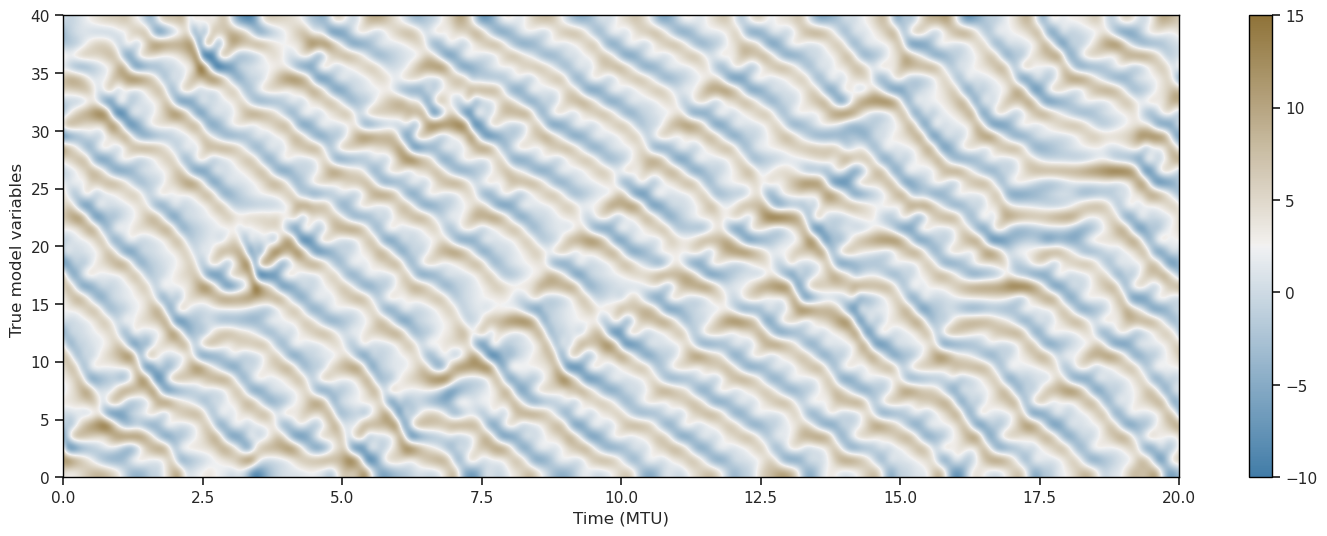

In [12]:
#Plot the true forecast
fig = plt.figure(figsize=(18, 6))
plt.grid(False)
im = plt.imshow(Xtest[2].T, 
           aspect = 'auto',
           origin = 'lower',
           interpolation = 'spline36',
           cmap = sns.diverging_palette(240, 60, as_cmap=True),
           extent = [0, dt*Xtest[2].shape[0], 0, Nx],
           vmin = -10,
           vmax = 15)
plt.colorbar(im)
plt.xlabel('Time (MTU)')
plt.ylabel('True model variables ')
plt.tick_params(direction='out', left=True, bottom=True)
plt.show()

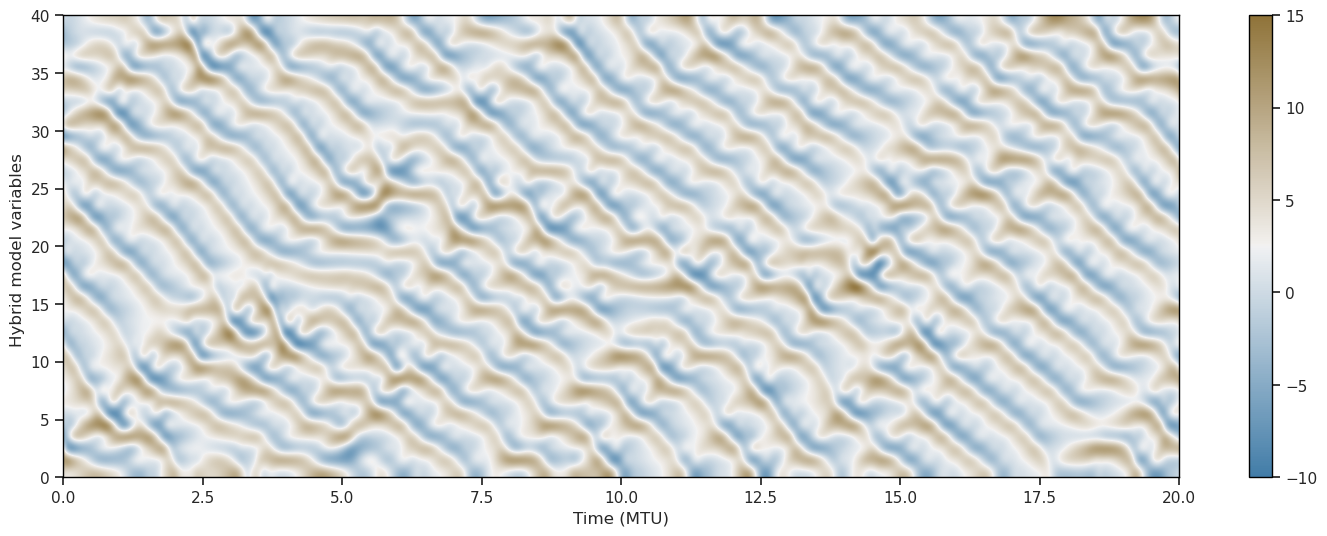

In [13]:
#Plot the hybrid forecast
fig = plt.figure(figsize=(18, 6))
plt.grid(False)
im = plt.imshow(xhyb[2].T, 
           aspect = 'auto',
           origin = 'lower',
           interpolation = 'spline36',
           cmap = sns.diverging_palette(240, 60, as_cmap=True),
           extent = [0, dt*Xtest[2].shape[0], 0, Nx],
           vmin = -10,
           vmax = 15)
plt.colorbar(im)
plt.xlabel('Time (MTU)')
plt.ylabel('Hybrid model variables ')
plt.tick_params(direction='out', left=True, bottom=True)
plt.show()

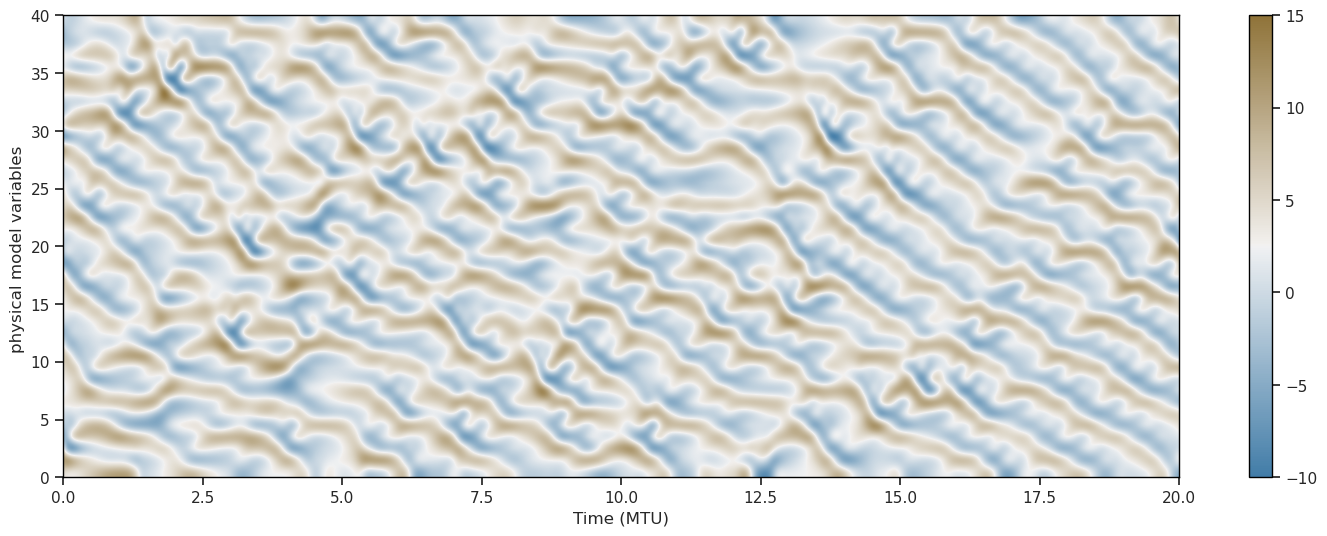

In [14]:
#Plot the physical forecast
fig = plt.figure(figsize=(18, 6))
plt.grid(False)
im = plt.imshow(xphi[2].T, 
           aspect = 'auto',
           origin = 'lower',
           interpolation = 'spline36',
           cmap = sns.diverging_palette(240, 60, as_cmap=True),
           extent = [0, dt*Xtest[2].shape[0], 0, Nx],
           vmin = -10,
           vmax = 15)
plt.colorbar(im)
plt.xlabel('Time (MTU)')
plt.ylabel('physical model variables ')
plt.tick_params(direction='out', left=True, bottom=True)
plt.show()

Quantitatively, it is expected that all these simulations, even though they share the same initial conditions, will start diverging from each other after some time. This is due to the chaotic nature of our model. 

Qualitatively, we can look at the general aspect (the variability) of each of these simulations. The simulations from the truth and the hybrid model are very similar. It is difficult to distinguish which one has been generated by the true model and which one has been generated by the hybrid model. When it comes to the physical model, even though the general variability is very close, we can spot some differences. The physical model has much more small-scale variability than the true model, it looks less regular, more chaotic. It shows that the underlying variability of the physical model is different from the one of the hybrid or true model.

In [15]:
# We compute the RMSE of the physical and of the hybrid model. 
rmse_phi = np.sqrt(np.mean(np.square(Xtest-xphi),axis=(0,2))/2)
rmse_hyb = np.sqrt(np.mean(np.square(Xtest-xhyb),axis=(0,2))/2)
mod_var = np.std(xtest)

We have also computed the model variability since the RMSE is expected to converge toward the model variability once the initial condition has been "forgotten" (which is due here also to the chaotic nature of the model).

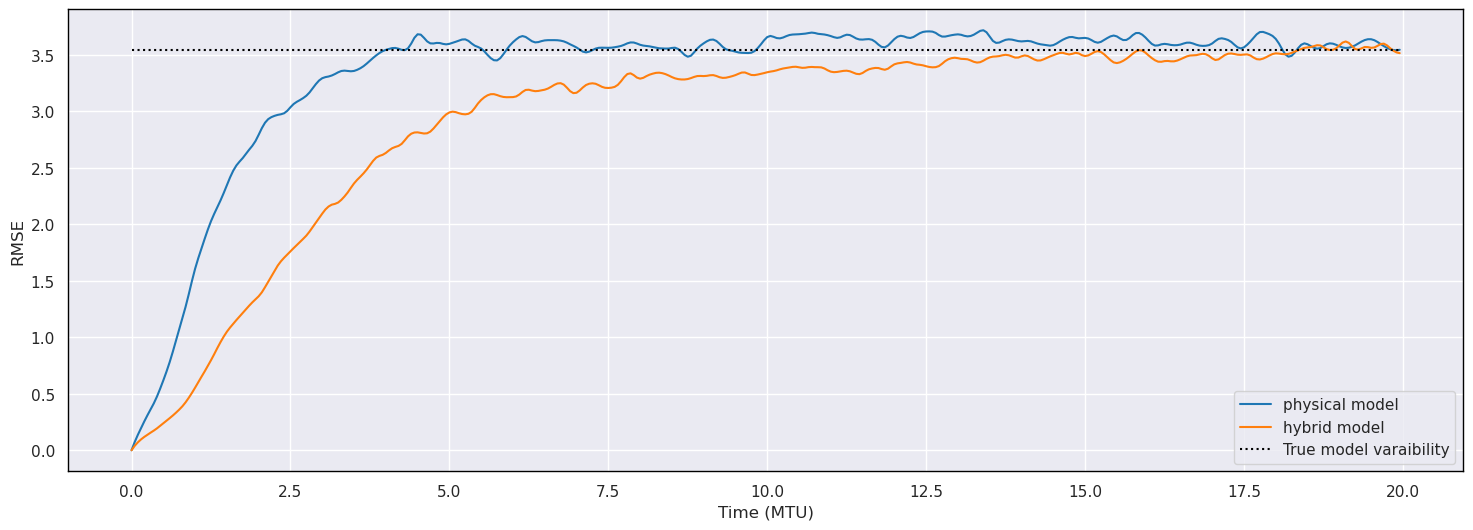

In [16]:
fig = plt.figure(figsize=(18, 6))
plt.plot(dt*np.arange(Nt_forecast), rmse_phi, label='physical model')
plt.plot(dt*np.arange(Nt_forecast), rmse_hyb, label='hybrid model')
plt.plot(dt*np.arange(Nt_forecast), mod_var*np.ones(Nt_forecast),':k', label='True model varaibility')
plt.legend()
plt.xlabel('Time (MTU)')
plt.ylabel('RMSE')
plt.savefig(f'Figures/rmse_{name}')

This RMSE has been averaged over $m$ forecasts, each one starting from a different initial condition.

At time 0, as the initial condition is extracted from the true simulation, the RMSE is zero.
As the lead time increases, the RMSE also increases, but it can be noticed that the error of the hybrid model is inferior to the error of the physical model. It shows that the hybrid model has a better forecast skill than the physical model, and it is due to the fact that **the neural network has efficiently corrected the model error.**